In [1]:
from __future__ import print_function

import numpy as np
import pandas as pd
import collections
from mpl_toolkits.mplot3d import Axes3D
from IPython import display
from matplotlib import pyplot as plt
from IPython.display import display
import seaborn as sns
import sklearn
import sklearn.manifold
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
tf.logging.set_verbosity(tf.logging.ERROR)

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from collections import Counter, defaultdict
from operator import itemgetter
import tensorflow as tf
from tensorflow import keras
from pylab import rcParams
from pylab import savefig
import lightfm
from lightfm import LightFM
from lightfm.data import Dataset
from lightfm import cross_validation
from lightfm.evaluation import precision_at_k
from lightfm.evaluation import recall_at_k
from lightfm.cross_validation import random_train_test_split
from scipy.sparse import csr_matrix
import scipy

from sklearn.model_selection import train_test_split
from collections import Counter, defaultdict
from sklearn.metrics import accuracy_score
import matplotlib.ticker as ticker
from math import sqrt
from sklearn.metrics import mean_squared_error

C:\Users\user\anaconda3\lib\site-packages\lightfm\_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


In [3]:
# Install Altair and activate its colab renderer.
#print("Installing Altair...")
#!pip install git+git://github.com/altair-viz/altair.git
#import altair as alt
#alt.data_transformers.enable('default', max_rows=None)
#alt.renderers.enable('colab')
#print("Done installing Altair.")

# Install spreadsheets and import authentication module.
#USER_RATINGS = False
#!pip install --upgrade -q gspread
#from google.colab import auth
#import gspread
#from oauth2client.client import GoogleCredentials

In [4]:
import matplotlib.pyplot as plt
import os
import warnings
from keras.layers import Input, Embedding, Flatten, Dot, Dense, Concatenate
from keras.models import Model

Firstly, I converted my data files from .dat to .csv format. I did this via excel using the data tab and it's "get external data" option and extracted it from text. All the delimiting was done by default and I had my files in a delimited format.

In [5]:
df = pd.read_csv("data/hetrec2011-lastfm-2k/artists.csv")
df

,id,name,url,pictureURL
0,1,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,http://userserve-ak.last.fm/serve/252/10808.jpg
1,2,Diary of Dreams,http://www.last.fm/music/Diary+of+Dreams,http://userserve-ak.last.fm/serve/252/3052066.jpg
2,3,Carpathian Forest,http://www.last.fm/music/Carpathian+Forest,http://userserve-ak.last.fm/serve/252/40222717...
3,4,Moi dix Mois,http://www.last.fm/music/Moi+dix+Mois,http://userserve-ak.last.fm/serve/252/54697835...
4,5,Bella Morte,http://www.last.fm/music/Bella+Morte,http://userserve-ak.last.fm/serve/252/14789013...
...,...,...,...,...
17627,18741,Diamanda GalÃ¡s,http://www.last.fm/music/Diamanda+Gal%C3%A1s,http://userserve-ak.last.fm/serve/252/16352971...
17628,18742,Aya RL,http://www.last.fm/music/Aya+RL,http://userserve-ak.last.fm/serve/252/207445.jpg
17629,18743,Coptic Rain,http://www.last.fm/music/Coptic+Rain,http://userserve-ak.last.fm/serve/252/344868.jpg
17630,18744,Oz Alchemist,http://www.last.fm/music/Oz+Alchemist,http://userserve-ak.last.fm/serve/252/29297695...


In [6]:
df['id'] = pd.to_numeric(df['id'])
lst = []
m = np.array(df['id'])
for i in range(0,17632):
    #print(i)
    if i not in df.id.values:
        lst.append(i)

len(lst)

965

In [7]:
newart = []
for i in range(0, 17632):
    newart.append(i)

In [8]:
newart = np.array(newart)
df['artID'] = newart.tolist()

In [9]:
df.drop(columns=['id'], inplace=True)
df.head()

,name,url,pictureURL,artID
0,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,http://userserve-ak.last.fm/serve/252/10808.jpg,0
1,Diary of Dreams,http://www.last.fm/music/Diary+of+Dreams,http://userserve-ak.last.fm/serve/252/3052066.jpg,1
2,Carpathian Forest,http://www.last.fm/music/Carpathian+Forest,http://userserve-ak.last.fm/serve/252/40222717...,2
3,Moi dix Mois,http://www.last.fm/music/Moi+dix+Mois,http://userserve-ak.last.fm/serve/252/54697835...,3
4,Bella Morte,http://www.last.fm/music/Bella+Morte,http://userserve-ak.last.fm/serve/252/14789013...,4


There appears to be some unclean names such as "Diamanda GalÃ¡s" among others just taking an initial look at the data here.

In [10]:
df1 = pd.read_csv("data/hetrec2011-lastfm-2k/tags.csv")
df1

,tagID,tagValue
0,1,metal
1,2,alternative metal
2,3,goth rock
3,4,black metal
4,5,death metal
...,...,...
11941,12644,suomi
11942,12645,symbiosis
11943,12646,sverige
11944,12647,eire


In [11]:
df2 = pd.read_csv("data/hetrec2011-lastfm-2k/user_artists.csv")
df2

,userID,artistID,weight
0,2,51,13883
1,2,52,11690
2,2,53,11351
3,2,54,10300
4,2,55,8983
...,...,...,...
92829,2100,18726,337
92830,2100,18727,297
92831,2100,18728,281
92832,2100,18729,280


In [12]:
df2['artistID'].min()

1

In [13]:
# Since the ids start at 2, we get them to start at 0. We also need to have the max value 1 less than the no of unique values.
df2["userID"] = df2["userID"].apply(lambda x: str(x-2))
df2["artistID"] = df2["artistID"].apply(lambda x: str(x-1))

In [14]:
df2['userID'] = df2['userID'].astype(int)
xyz =  np.array(df2['userID'])
#zzz = np.array(played['userID'])
vals = []
for i in range(len(xyz)):
    v = xyz[i]
    if v not in vals:
        vals.append(v)
    else:
        continue

In [15]:
vals[-1]

2098

In [16]:
unique_list = list(set(vals))
unique_list.sort()
unique_list[-1]

2098

In [17]:
usenew = []
for i in range(0, 1892):
    usenew.append(i)

usenew[-1]

1891

In [18]:
keys = unique_list
values = usenew
dictionary = dict(zip(keys, values))
#print(dictionary) # {'a': 1, 'b': 2, 'c': 3}

In [19]:
s = df2['userID']

df2['userID'] = s.map(dictionary)

In [20]:
df2.head()

,userID,artistID,weight
0,0,50,13883
1,0,51,11690
2,0,52,11351
3,0,53,10300
4,0,54,8983


In [21]:
df2['artistID'] = df2['artistID'].astype(int)
xyz =  np.array(df2['artistID'])
#zzz = np.array(played['userID'])
vals = []
for i in range(len(xyz)):
    v = xyz[i]
    if v not in vals:
        vals.append(v)
    else:
        continue

In [22]:
unique_list = list(set(vals))
unique_list.sort()
unique_list[0]

0

In [23]:
usenew = []
for i in range(0, 17632):
    usenew.append(i)

usenew[-1]

17631

In [24]:
keys = unique_list
values = usenew
diction = dict(zip(keys, values))
#print(diction) # {'a': 1, 'b': 2, 'c': 3}

In [25]:
s = df2['artistID']

df2['artistID'] = s.map(diction)

In [26]:
df2['weight'].max()

352698

In [27]:
df2

,userID,artistID,weight
0,0,45,13883
1,0,46,11690
2,0,47,11351
3,0,48,10300
4,0,49,8983
...,...,...,...
92829,1891,17615,337
92830,1891,17616,297
92831,1891,17617,281
92832,1891,17618,280


In [28]:
df3 = pd.read_csv("data/hetrec2011-lastfm-2k/user_friends.csv")
df3

,userID,friendID
0,2,275
1,2,428
2,2,515
3,2,761
4,2,831
...,...,...
25429,2099,1801
25430,2099,2006
25431,2099,2016
25432,2100,586


In [29]:
# Since the ids start at 2, we get them to start at 0. We also need to have the max value 1 less than the no of unique values.
df3["userID"] = df3["userID"].apply(lambda x: str(x-2))
df3["friendID"] = df3["friendID"].apply(lambda x: str(x-2))

df3['userID'] = pd.to_numeric(df3['userID'])
df3['friendID'] = pd.to_numeric(df3['friendID'])

In [30]:
df3['friendID'].max()

2098

In [31]:
df3['friendID'].nunique()

1892

In [32]:
xyz =  np.array(df3['userID'])
#zzz = np.array(df2['userID'])
vals = []
for i in range(len(xyz)):
    if xyz[i] not in vals:
        vals.append(xyz[i])

In [33]:
unique_list = list(set(vals))
unique_list.sort()
unique_list[-1]

2098

In [34]:
usenew = []
for i in range(0, 1892):
    usenew.append(i)

usenew[-1]

1891

In [35]:
keys = unique_list
values = usenew
dictionary = dict(zip(keys, values))
#print(dictionary) # {'a': 1, 'b': 2, 'c': 3}

In [36]:
s = df3['userID']

df3['userID'] = s.map(dictionary)

In [37]:
o = df3['friendID']

df3['friendID'] = o.map(dictionary)

In [38]:
df3['friendID'].max()

1891

In [39]:
df3.isnull().values.any()

False

In [40]:
df4 = pd.read_csv("data/hetrec2011-lastfm-2k/user_taggedartists-timestamps.csv")
df4

,userID,artistID,tagID,day,month,year
0,2,52,13,1,4,2009
1,2,52,15,1,4,2009
2,2,52,18,1,4,2009
3,2,52,21,1,4,2009
4,2,52,41,1,4,2009
...,...,...,...,...,...,...
186474,2100,16437,4,1,7,2010
186475,2100,16437,292,1,5,2010
186476,2100,16437,2087,1,7,2010
186477,2100,16437,2801,1,5,2010


In [41]:
df5 = pd.read_csv("data/hetrec2011-lastfm-2k/user_taggedartists.csv")
df5.head()

,userID,artistID,tagID,day,month,year
0,2,52,13,1,4,2009
1,2,52,15,1,4,2009
2,2,52,18,1,4,2009
3,2,52,21,1,4,2009
4,2,52,41,1,4,2009


Our last two dataframes seem exactly the same. Let's check this before we delete anything.

In [42]:
def checkequality(A, B):

    df11 = A.sort_index(axis=1)
    df11 = df11.sort_values(df11.columns.tolist()).reset_index(drop=True)

    df22 = B.sort_index(axis=1)
    df22 = df22.sort_values(df22.columns.tolist()).reset_index(drop=True)
    return (df11 == df22).values.all()

a = checkequality(df4, df5)
print (a)

True


Two of our files are exactly the same. We can delete one of these accordingly.

In [43]:
del df5

In [44]:
# Since the ids start at 2, we get them to start at 0. We also need to have the max value 1 less than the no of unique values.
df4["userID"] = df4["userID"].apply(lambda x: str(x-2))
df4["artistID"] = df4["artistID"].apply(lambda x: str(x-1))

df4['artistID'] = df4['artistID'].astype(int)
df4['userID'] = df4['userID'].astype(int)

In [45]:
xyz =  np.array(df4['artistID'])
#zzz = np.array(played['userID'])
vals = []
for i in range(len(xyz)):
    v = xyz[i]
    if v not in vals:
        vals.append(v)
    else:
        continue

In [46]:
unique_list = list(set(vals))
unique_list.sort()
print(unique_list[-1])

usenew = []
for i in range(0, 17632):
    usenew.append(i)

usenew[-1]

18743


17631

In [47]:
keys = unique_list
values = usenew
diction = dict(zip(keys, values))
#print(diction) # {'a': 1, 'b': 2, 'c': 3}

In [48]:
s = df4['artistID']

df4['artistID'] = s.map(diction)

In [49]:
s = df4['userID']

df4['userID'] = s.map(dictionary)
#print(dictionary)

In [50]:
df4

,userID,artistID,tagID,day,month,year
0,0,49,13,1,4,2009
1,0,49,15,1,4,2009
2,0,49,18,1,4,2009
3,0,49,21,1,4,2009
4,0,49,41,1,4,2009
...,...,...,...,...,...,...
186474,1891,11288,4,1,7,2010
186475,1891,11288,292,1,5,2010
186476,1891,11288,2087,1,7,2010
186477,1891,11288,2801,1,5,2010


In [51]:
df4.drop(columns=['day', 'month', 'year'], inplace=True)

In [52]:
tags = pd.merge(df1, df4, how="inner", left_on="tagID", right_on="tagID")
tags.isnull().values.any()
tags['artistID'].max()

12522

# Methodology
Now that all our data files are read in and in the appropriate format we will begin our end to end process. These are as follows:
##### 1. Data cleaning and processing
##### 2. Visualization
##### 3. Fitting our Model
##### 4. Evaluating our Model

# Cleaning and Processing

### Initial analysis and cleaning

In [53]:
df['name'].value_counts()

MALICE MIZER                        1
BEAT!BEAT!BEAT!                     1
ãƒˆã‚¯ãƒžãƒ«ã‚·ãƒ¥ãƒ¼ã‚´            1
Thao with The Get Down Stay Down    1
ãƒªã‚¢ãƒ»ãƒ‡ã‚£ã‚¾ãƒ³               1
                                   ..
Innerpartysystem                    1
Helia                               1
Devil Sold His Soul                 1
Nevea Tears                         1
Grzegorz Tomczak                    1
Name: name, Length: 17632, dtype: int64

In [54]:
df1['tagID'].value_counts()

1        1
8368     1
8359     1
8360     1
8361     1
        ..
4059     1
4060     1
4061     1
4062     1
12648    1
Name: tagID, Length: 11946, dtype: int64

After initial observation, I feel the timestamp dataframe is of little use to me and hence disregard it. As per the readme file we have 1892 users and 17632 artists in our data.

In [55]:
dfs = [df, df1, df2, df3, df4]
na = []
for i in range(len(dfs)):
    if dfs[i].isnull().values.any() > 0:
        na.append(dfs[i])

In [56]:
na

[                    name                                           url  \
 0           MALICE MIZER         http://www.last.fm/music/MALICE+MIZER   
 1        Diary of Dreams      http://www.last.fm/music/Diary+of+Dreams   
 2      Carpathian Forest    http://www.last.fm/music/Carpathian+Forest   
 3           Moi dix Mois         http://www.last.fm/music/Moi+dix+Mois   
 4            Bella Morte          http://www.last.fm/music/Bella+Morte   
 ...                  ...                                           ...   
 17627    Diamanda GalÃ¡s  http://www.last.fm/music/Diamanda+Gal%C3%A1s   
 17628             Aya RL               http://www.last.fm/music/Aya+RL   
 17629        Coptic Rain          http://www.last.fm/music/Coptic+Rain   
 17630       Oz Alchemist         http://www.last.fm/music/Oz+Alchemist   
 17631   Grzegorz Tomczak     http://www.last.fm/music/Grzegorz+Tomczak   
 
                                               pictureURL  artID  
 0        http://userserve-ak.l

The only dataframe with nulls is our artists dataframe. Let's investigate this further to see if there is any important missing values such as ID's etc.

In [57]:
df.dtypes

name          object
url           object
pictureURL    object
artID          int64
dtype: object

In [58]:
features_with_na = [features for features in df.columns if df[features].isnull().sum() > 0]

for feature in features_with_na: 
    print(feature, np.round(df[feature].isnull().mean(), 4), '% missing values')
    print(features_with_na)

pictureURL 0.0252 % missing values
['pictureURL']


This is a positive result as there are very few null values in the dataframe and the small amount that exist are in a column of lesser important that we will not need to impute missing values for.

In [59]:
played = pd.merge(df, df2, how="inner", left_on="artID", right_on="artistID")
played.rename(columns={"weight": "played"}, inplace=True)

We will drop the pictureURL column as there is not much information to be gained and there is some nulls present.

In [60]:
played.drop(columns=['pictureURL'], inplace=True)

# Last Method

In [163]:
ratings_df = played.pivot(
    index='userID', 
    columns='artistID', 
    values='playedUserNorm'
)

In [164]:
ratings = ratings_df.fillna(0).values

In [165]:
sparsity = float(len(ratings.nonzero()[0]))
sparsity /= (ratings.shape[0] * ratings.shape[1])
sparsity *= 100
print('{:.2f}%'.format(sparsity))

0.28%


In [166]:
MIN_USER_RATINGS = 35
DELETE_RATING_COUNT = 15

def traintest_split(ratings):
    
    validation = np.zeros(ratings.shape)
    train = ratings.copy()
    
    for user in np.arange(ratings.shape[0]):
        if len(ratings[user,:].nonzero()[0]) >= MIN_USER_RATINGS:
            val_ratings = np.random.choice(
                ratings[user, :].nonzero()[0], 
                size=DELETE_RATING_COUNT,
                replace=False
            )
            train[user, val_ratings] = 0
            validation[user, val_ratings] = ratings[user, val_ratings]
    return train, validation

In [167]:
train, val = traintest_split(ratings)

In [168]:
train.shape

(1892, 17632)

In [169]:
def rmse(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()].flatten() 
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    return sqrt(mean_squared_error(prediction, ground_truth))

In [170]:
class Recommender:
  
  def __init__(self, n_epochs=200, n_latent_features=3, lmbda=0.1, learning_rate=0.001):
    self.n_epochs = n_epochs
    self.n_latent_features = n_latent_features
    self.lmbda = lmbda
    self.learning_rate = learning_rate
  
  def predictions(self, P, Q):
    return np.dot(P.T, Q)
  
  def fit(self, X_train, X_val):
    m, n = X_train.shape

    self.P = 3 * np.random.rand(self.n_latent_features, m)
    self.Q = 3 * np.random.rand(self.n_latent_features, n)
    
    self.train_error = []
    self.val_error = []

    users, items = X_train.nonzero()
    
    for epoch in range(self.n_epochs):
        for u, i in zip(users, items):
            error = X_train[u, i] - self.predictions(self.P[:,u], self.Q[:,i])
            self.P[:, u] += self.learning_rate * (error * self.Q[:, i] - self.lmbda * self.P[:, u])
            self.Q[:, i] += self.learning_rate * (error * self.P[:, u] - self.lmbda * self.Q[:, i])

        train_rmse = rmse(self.predictions(self.P, self.Q), X_train)
        val_rmse = rmse(self.predictions(self.P, self.Q), X_val)
        self.train_error.append(train_rmse)
        self.val_error.append(val_rmse)
        
    return self
  
  def predict(self, X_train, user_index):
    y_hat = self.predictions(self.P, self.Q)
    predictions_index = np.where(X_train[user_index, :] == 0)[0]
    return y_hat[user_index, predictions_index].flatten()

In [171]:
recommender = Recommender().fit(train, val)

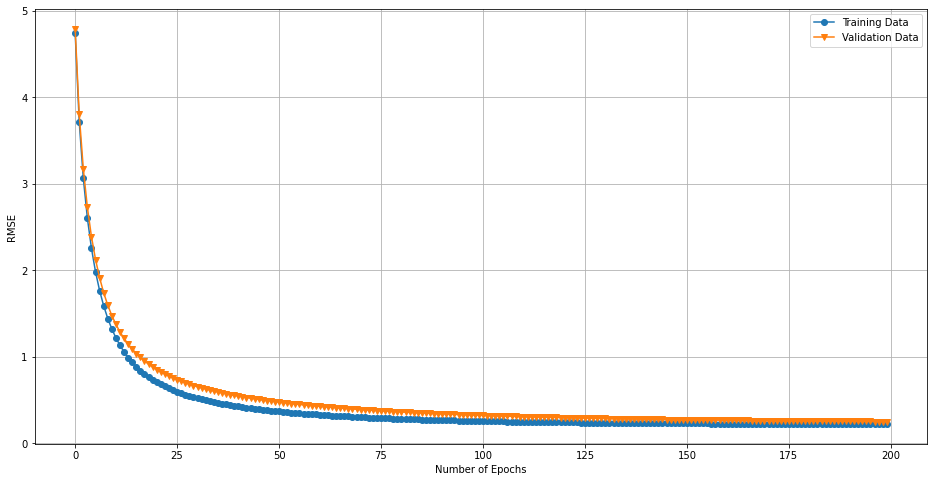

In [172]:
plt.figure(figsize=(16,8))
plt.plot(range(recommender.n_epochs), recommender.train_error, marker='o', label='Training Data');
plt.plot(range(recommender.n_epochs), recommender.val_error, marker='v', label='Validation Data');
plt.xlabel('Number of Epochs');
plt.ylabel('RMSE');
plt.legend()
plt.grid()
plt.show()

## Making Recommendations

In [173]:
user_id = 83
user_index = ratings_df.index.get_loc(user_id)
predictions_index = np.where(train[user_index, :] == 0)[0]

rating_predictions = recommender.predict(train, user_index)

In [174]:
def create_artist_ratings(artists_df, artists_index, ratings, n=10):
    artist_ids = ratings_df.columns[artists_index]
    artist_ratings = pd.DataFrame(data=dict(artistId=artist_ids, rating=ratings))
    top_n_artists = artist_ratings.sort_values("rating", ascending=False).head(n)
  
    artist_recommendations = artists_df[artists_df.artID.isin(top_n_artists.artistId)].reset_index(drop=True)
    artist_recommendations['rating'] = pd.Series(top_n_artists.rating.values)
    return artist_recommendations.sort_values("rating", ascending=False)

In [175]:
existing_ratings_index = np.where(train[user_index, :] > 0)[0]
existing_ratings = train[user_index, existing_ratings_index]

create_artist_ratings(df, existing_ratings_index, existing_ratings)

,name,url,pictureURL,artID,rating
0,Janet Jackson,http://www.last.fm/music/Janet+Jackson,http://userserve-ak.last.fm/serve/252/4245358.jpg,279,1.000000
1,Christina Aguilera,http://www.last.fm/music/Christina+Aguilera,http://userserve-ak.last.fm/serve/252/47363849...,286,0.689394
2,Leona Lewis,http://www.last.fm/music/Leona+Lewis,http://userserve-ak.last.fm/serve/252/45104681...,288,0.643939
3,P!nk,http://www.last.fm/music/P%21nk,http://userserve-ak.last.fm/serve/252/56011579...,296,0.613636
4,Nelly Furtado,http://www.last.fm/music/Nelly+Furtado,http://userserve-ak.last.fm/serve/252/327744.jpg,304,0.575758
5,Jessica Simpson,http://www.last.fm/music/Jessica+Simpson,http://userserve-ak.last.fm/serve/252/44836897...,459,0.500000
6,Gwen Stefani,http://www.last.fm/music/Gwen+Stefani,http://userserve-ak.last.fm/serve/252/8516439.jpg,519,0.469697
7,Sophie Ellis-Bextor,http://www.last.fm/music/Sophie+Ellis-Bextor,http://userserve-ak.last.fm/serve/252/61811325...,529,0.462121
8,Cyndi Lauper,http://www.last.fm/music/Cyndi+Lauper,http://userserve-ak.last.fm/serve/252/6967243.jpg,880,0.462121
9,Alejandra GuzmÃ¡n,http://www.last.fm/music/Alejandra+Guzm%C3%A1n,http://userserve-ak.last.fm/serve/252/36319033...,2376,0.446970


In [176]:
create_artist_ratings(df, predictions_index, rating_predictions)

,name,url,pictureURL,artID,rating
0,kenneth e Danilo,http://www.last.fm/music/kenneth+e+Danilo,NaN,5472,1.498642
1,Hick,http://www.last.fm/music/Hick,http://userserve-ak.last.fm/serve/252/53058311...,5862,1.494241
2,Satariel,http://www.last.fm/music/Satariel,http://userserve-ak.last.fm/serve/252/3527524.jpg,6676,1.485870
3,"Arj Barker, Doug Benson & Tony Camin",http://www.last.fm/music/Arj%2BBarker%252C%2BD...,http://userserve-ak.last.fm/serve/252/55510411...,6680,1.483970
4,Sampa Crew,http://www.last.fm/music/Sampa+Crew,http://userserve-ak.last.fm/serve/252/55678243...,8935,1.480258
5,è©©æœˆã‚«ã‚ªãƒª,http://www.last.fm/music/%E8%A9%A9%E6%9C%88%E3...,http://userserve-ak.last.fm/serve/252/33179955...,9971,1.478831
6,Tiromancino,http://www.last.fm/music/Tiromancino,http://userserve-ak.last.fm/serve/252/504510.jpg,11113,1.473183
7,Lizzy Borden,http://www.last.fm/music/Lizzy+Borden,http://userserve-ak.last.fm/serve/252/37719891...,12462,1.469922
8,Gothika,http://www.last.fm/music/Gothika,http://userserve-ak.last.fm/serve/252/46281.jpg,16701,1.468896
9,Tristeria,http://www.last.fm/music/Tristeria,http://userserve-ak.last.fm/serve/252/41101533...,17013,1.464956


Let's run a similar evaluation process over our second alternate method. We will look at the same user ID of 83 and look at the recommendations it makes.

In [177]:
played[played['userID'] == 83]

,name,url,artID,userID,artistID,played,playedUserNorm,playCountScaled
1975,Madonna,http://www.last.fm/music/Madonna,61,83,61,108,0.818182,0.000303
5374,Enrique Iglesias,http://www.last.fm/music/Enrique+Iglesias,155,83,155,26,0.196970,0.000071
11971,Mariah Carey,http://www.last.fm/music/Mariah+Carey,251,83,251,25,0.189394,0.000068
12293,CÃ©line Dion,http://www.last.fm/music/C%C3%A9line+Dion,259,83,259,34,0.257576,0.000094
12593,Janet Jackson,http://www.last.fm/music/Janet+Jackson,279,83,279,85,0.643939,0.000238
12715,Rihanna,http://www.last.fm/music/Rihanna,282,83,282,20,0.151515,0.000054
13199,Britney Spears,http://www.last.fm/music/Britney+Spears,283,83,283,101,0.765152,0.000284
14065,Christina Aguilera,http://www.last.fm/music/Christina+Aguilera,286,83,286,132,1.000000,0.000371
14588,Leona Lewis,http://www.last.fm/music/Leona+Lewis,288,83,288,76,0.575758,0.000213
14758,BeyoncÃ©,http://www.last.fm/music/Beyonc%C3%A9,289,83,289,127,0.962121,0.000357


In [178]:
pre = create_artist_ratings(df, predictions_index, rating_predictions)
zzzz2 = pd.merge(pre, tags, how="inner", left_on=['artID'], right_on=['artistID'])

In [179]:
zzzz2['tagValue'].value_counts()

nu jazz              2
acoustic             2
80s                  2
hard rock            2
instrumental         2
hair metal           2
gabbacore            1
glam metal           1
contemporary jazz    1
favorite artist      1
jazz                 1
male vocalists       1
singer-songwriter    1
pop                  1
classic rock         1
1989                 1
rock                 1
alternative          1
synthpop             1
electronic           1
ambient              1
chillout             1
folk                 1
melancholy           1
reggae               1
Name: tagValue, dtype: int64

We can see again that our system appears to be recommending artists of popular genres / tags more so and not making relevant recommendations. It is good that it is making novel recommendations on one hand and giving the user a wider scope of music. However, it must be said it would be more advisable if it could make recommendations more similar to what a user listens to identifying less popular artists of similar genres that they may have missed. This recommender like our neural network recommender appears to be suffering from the "cold start" problem many recommenders encounter.